<a href="https://colab.research.google.com/github/chryssa-pat/Theory-Decision/blob/main/alphavantage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage'
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Συλλογή Δεδομένων**




In [14]:
import requests

#API_KEY = WUANR0CI7QBROL0X
#STOCK SYMBOL = GOOGL
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GOOGL&outputsize=full&apikey=WUANR0CI7QBROL0X'   # replace API KEY and stock symbol
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'GOOGL', '3. Last Refreshed': '2024-11-19', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-11-19': {'1. open': '173.7200', '2. high': '178.8700', '3. low': '173.5600', '4. close': '178.1200', '5. volume': '23434925'}, '2024-11-18': {'1. open': '173.4200', '2. high': '175.4380', '3. low': '172.9000', '4. close': '175.3000', '5. volume': '20206613'}, '2024-11-15': {'1. open': '173.7300', '2. high': '174.1400', '3. low': '171.2200', '4. close': '172.4900', '5. volume': '32504649'}, '2024-11-14': {'1. open': '178.2800', '2. high': '178.8200', '3. low': '174.3218', '4. close': '175.5800', '5. volume': '31007457'}, '2024-11-13': {'1. open': '180.4600', '2. high': '180.9600', '3. low': '178.5400', '4. close': '178.8800', '5. volume': '23184003'}, '2024-11-12': {'1. open': '179.8200', '2. high': '182.4900', '3. low': '179.3900', '4. close': '181.6200',

In [32]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part
time_series = data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = '/content/drive/MyDrive/alphavantage/close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")



Data saved to /content/drive/MyDrive/alphavantage/close_prices.csv


# **Προεπεξεργασία**




<Figure size 1400x700 with 0 Axes>

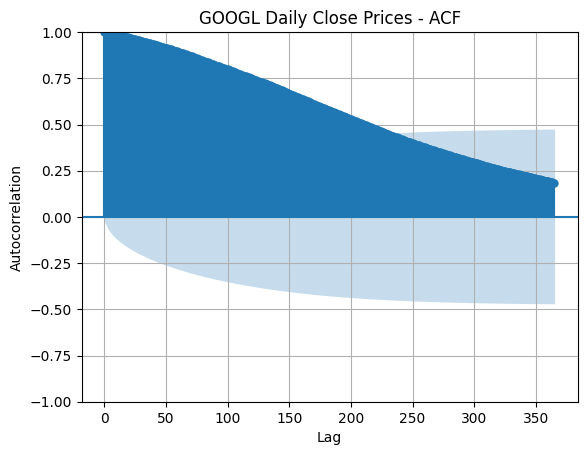

"\nfrom statsmodels.graphics.tsaplots import plot_pacf\n\nplt.figure(figsize=(12, 6))\nplot_pacf(df['Close'], lags=365)\nplt.title('GOOGL Daily Close Prices - PACF')\nplt.xlabel('Lag')\nplt.ylabel('Partial Autocorrelation')\nplt.grid(True)\nplt.show()\n"

In [22]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/alphavantage/close_prices.csv')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Apply Gaussian filter
df['Close_smoothed'] = gaussian_filter1d(df['Close'], sigma=4)

# Create the ACF plot
plt.figure(figsize=(14, 7))  # Adjust figure size as needed
plot_acf(df['Close_smoothed'], lags=365)
plt.title('GOOGL Daily Close Prices - ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()
"""
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))
plot_pacf(df['Close'], lags=365)
plt.title('GOOGL Daily Close Prices - PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()
"""

Η συγκεκριμένη γραφική δείχνει τη συνάρτηση αυτοσυσχέτισης (ACF) για τις ημερήσιες τιμές κλεισίματος της μετοχής Google (GOOGL):


1.	Η ACF ξεκινά κοντά στο 1 στο lag 0, υποδεικνύοντας ισχυρή αυτοσυσχέτιση στην αρχή, κάτι που είναι αναμενόμενο, καθώς μια χρονοσειρά συσχετίζεται πάντα τέλεια με τον εαυτό της. Για μικρές τιμές εξακολουθεί να υπάρχει ισχυρή συσχέτιση.
2.	Καθώς αυξάνουμε τα lag , η αυτοσυσχέτιση μειώνεται σταδιακά. Αυτό υποδηλώνει ότι οι ημερήσιες τιμές κλεισίματος της μετοχής της Google συσχετίζονται σε μεγάλο βαθμό σε μικρά χρονικά διαστήματα.
3.	Η ACF φθίνει σταδιακά, μέχρι  να πλησιάσει  σχεδόν το μηδέν. Αυτό δείχνει ότι σε μαγαλύτερα χρονικά διαστήματα η συσχέτιση μεταξύ των τιμών μειώνεται.



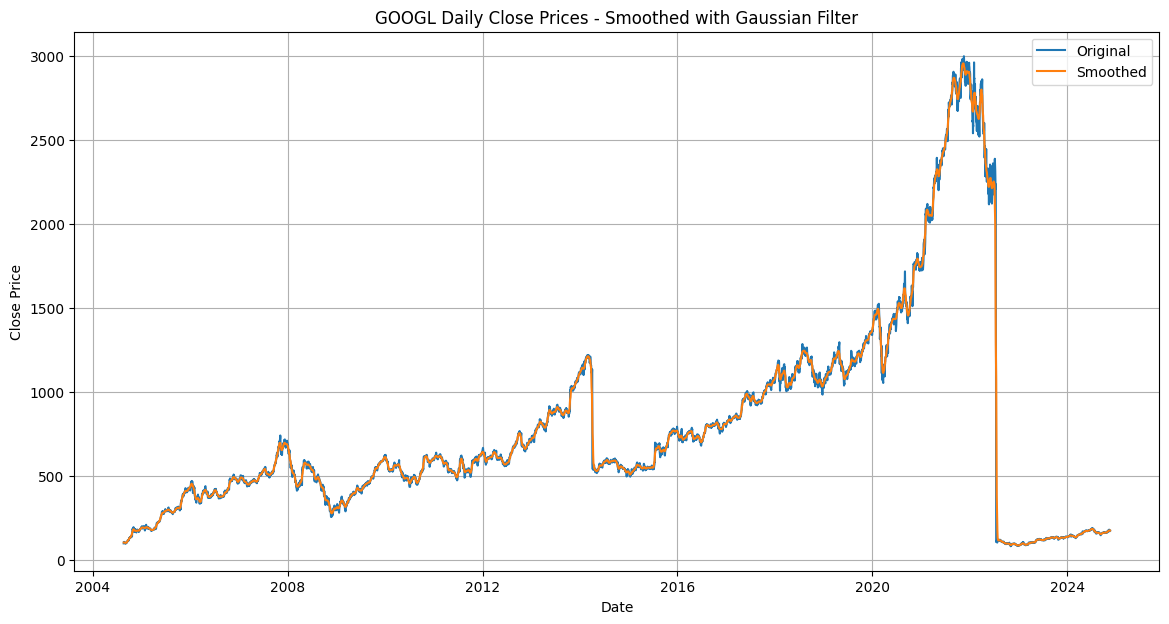

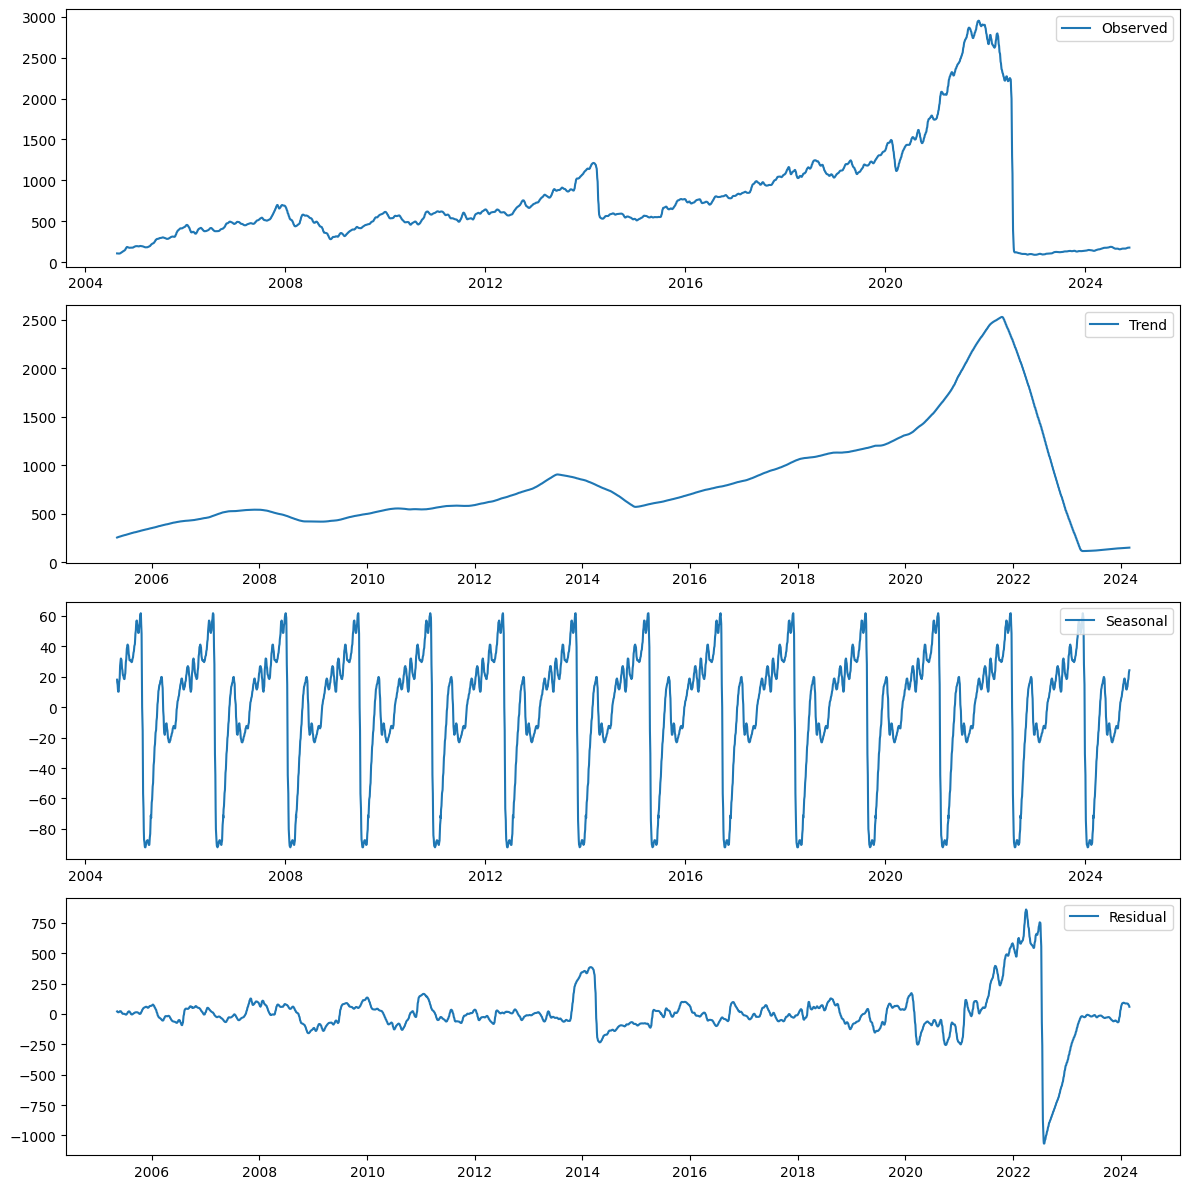

In [23]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the original and smoothed data
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Original')
plt.plot(df['Close_smoothed'], label='Smoothed')
plt.title('GOOGL Daily Close Prices - Smoothed with Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Close_smoothed'], model='additive', period=365)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
axes[0].plot(decomposition.observed, label='Observed')
axes[0].legend()
axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend()
axes[2].plot(decomposition.seasonal, label='Seasonal')
axes[2].legend()
axes[3].plot(decomposition.resid, label='Residual')
axes[3].legend()
plt.tight_layout()
plt.show()

Παρατηρήσεις απο την πρώτη γραφική:

1.	Μέχρι το 2020 οι τιμές κλεισίματος εμφανίζουν διακυμάνσεις, αλλά και  μια   σταθερή ανοδική τάση.
2.	Περίπου το 2021 παρατηρείται απότομη άνοδος της μετοχής.
3.	Τέλος, στα μέσα του 2022 υπάρχει ξαφνική πτώση της μετοχής, η οποία στην συνέχεια σταθεροποιείται σε πολύ χαμηλές τιμές με ελάχιστες διακυμάνσεις σε σύγκριση με τις προηγούμενες περιόδους.













--- Lags: 1 ---
Validation MSE: 0.5666315131761408
Validation RMSE: 0.752749303006081
Validation MAE: 0.6214900491711689
Linear Regression Equation:
y = 0.1503 + (0.9998) * close_t-1
Predicted vs Actual Close Prices:


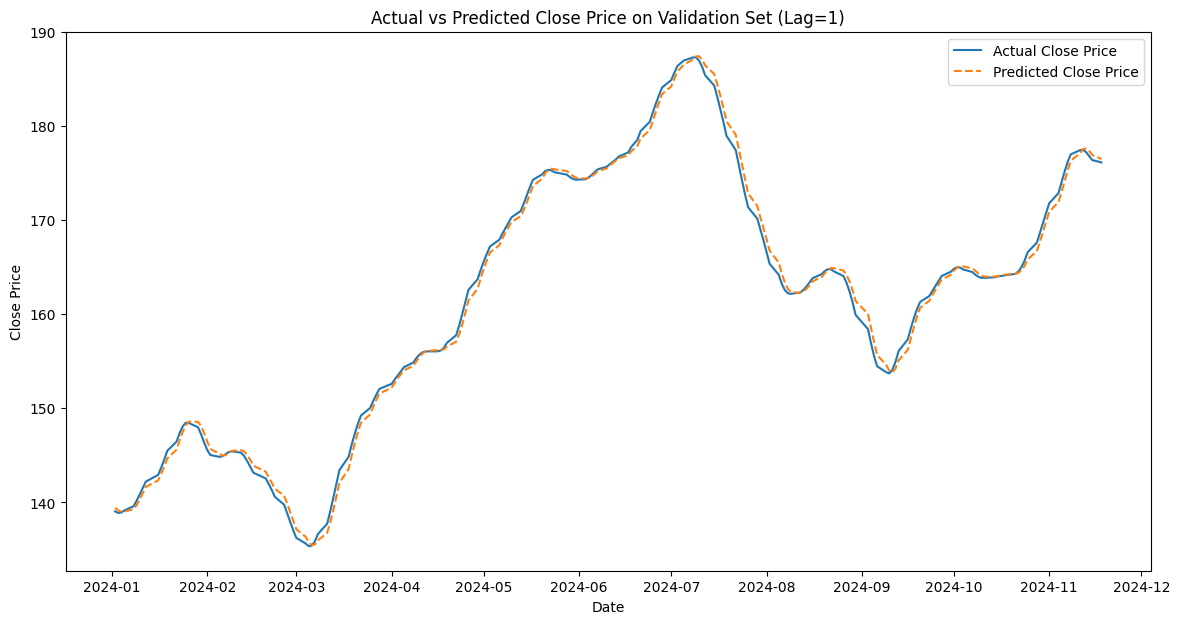


--- Lags: 2 ---
Validation MSE: 0.07001488312958021
Validation RMSE: 0.2646032560827251
Validation MAE: 0.22767450429252373
Linear Regression Equation:
y = 0.2630 + (1.9718) * close_t-1 + (-0.9721) * close_t-2
Predicted vs Actual Close Prices:


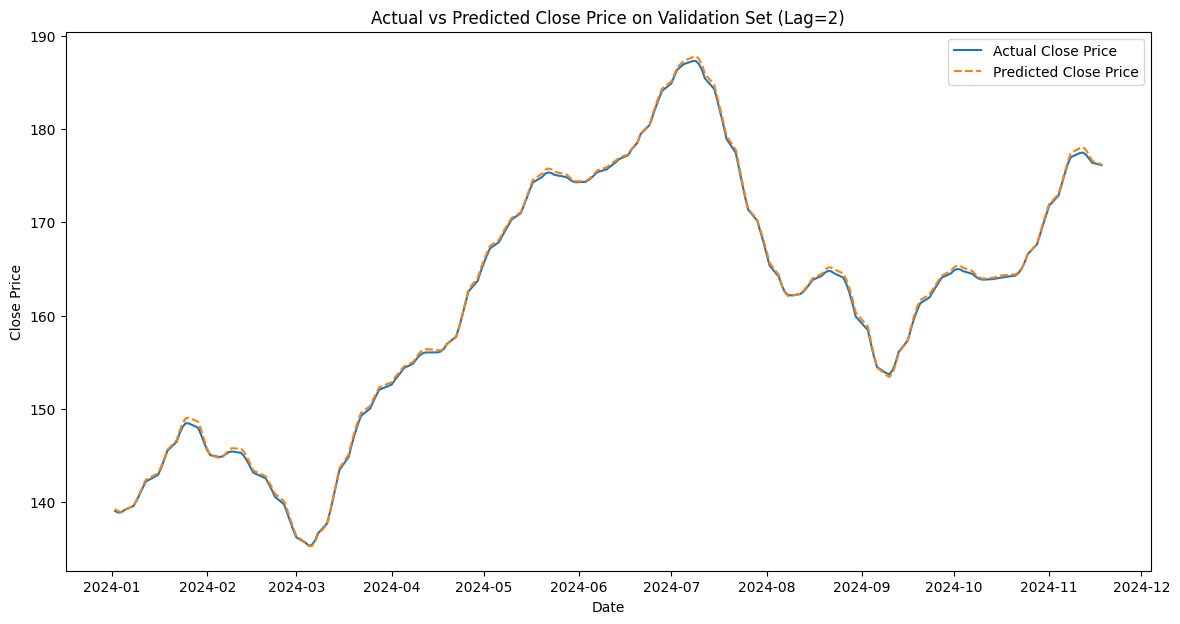


--- Lags: 3 ---
Validation MSE: 0.0033390303557124463
Validation RMSE: 0.057784343517188516
Validation MAE: 0.047518220172827925
Linear Regression Equation:
y = 0.0149 + (2.8924) * close_t-1 + (-2.8394) * close_t-2 + (0.9470) * close_t-3
Predicted vs Actual Close Prices:


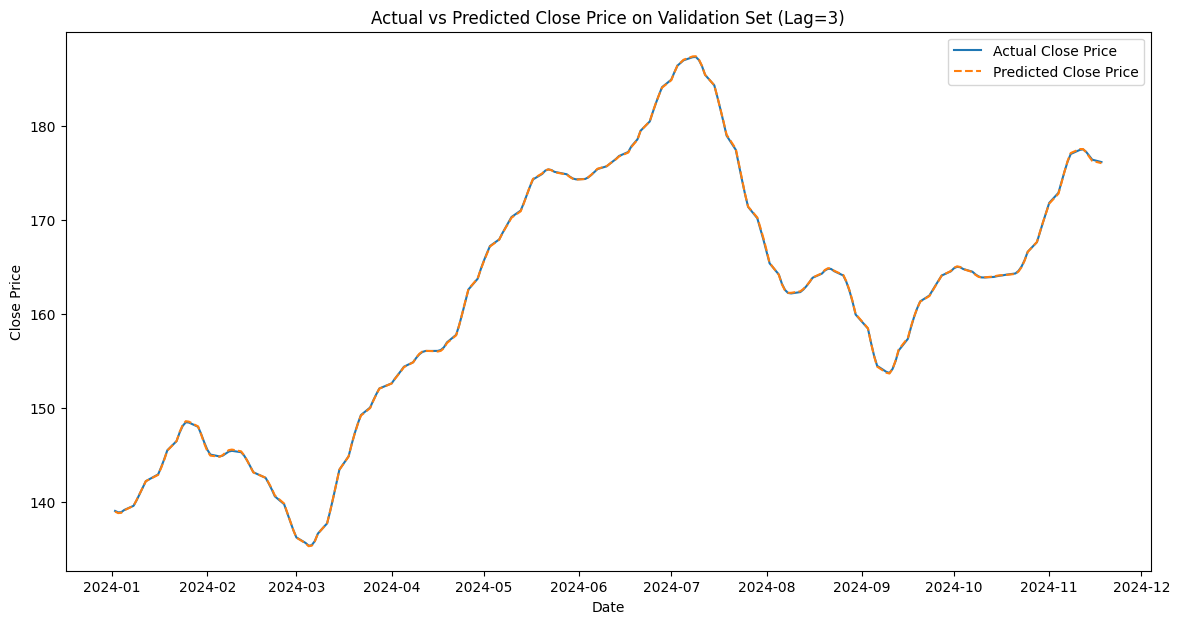


--- Lags: 4 ---
Validation MSE: 0.0010647297112459037
Validation RMSE: 0.03263019631025691
Validation MAE: 0.025952780376092346
Linear Regression Equation:
y = 0.0270 + (3.7691) * close_t-1 + (-5.4679) * close_t-2 + (3.6246) * close_t-3 + (-0.9258) * close_t-4
Predicted vs Actual Close Prices:


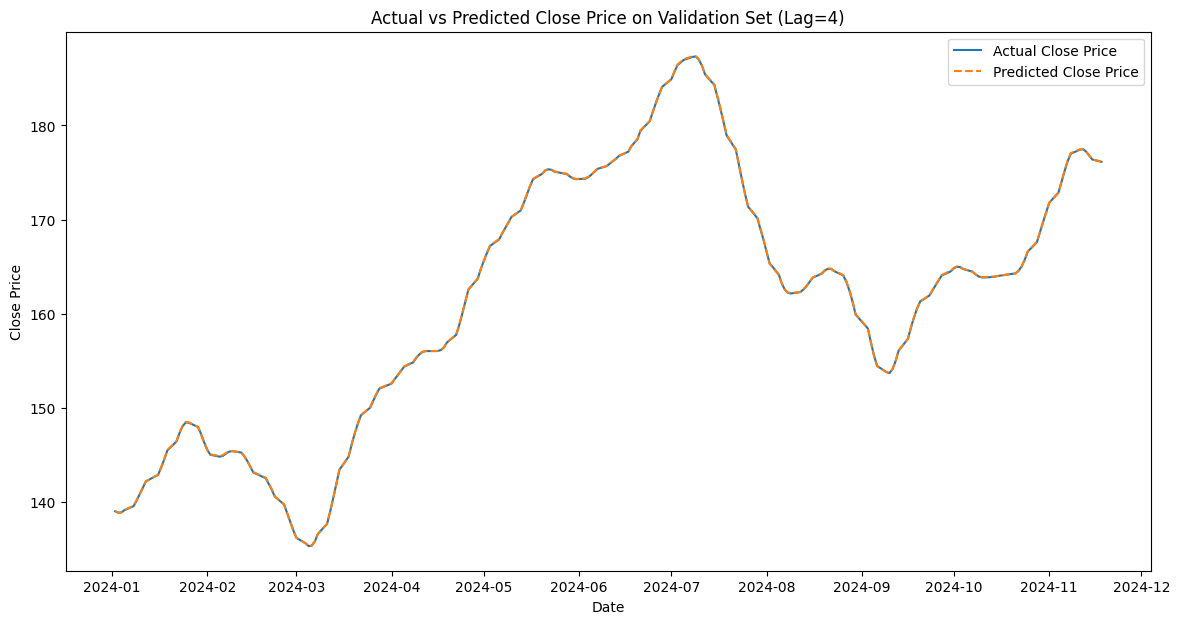


--- Lags: 5 ---
Validation MSE: 0.00012727938875162526
Validation RMSE: 0.011281816730989085
Validation MAE: 0.008702405654676261
Linear Regression Equation:
y = 0.0028 + (4.6010) * close_t-1 + (-8.7254) * close_t-2 + (8.5387) * close_t-3 + (-4.3130) * close_t-4 + (0.8987) * close_t-5
Predicted vs Actual Close Prices:


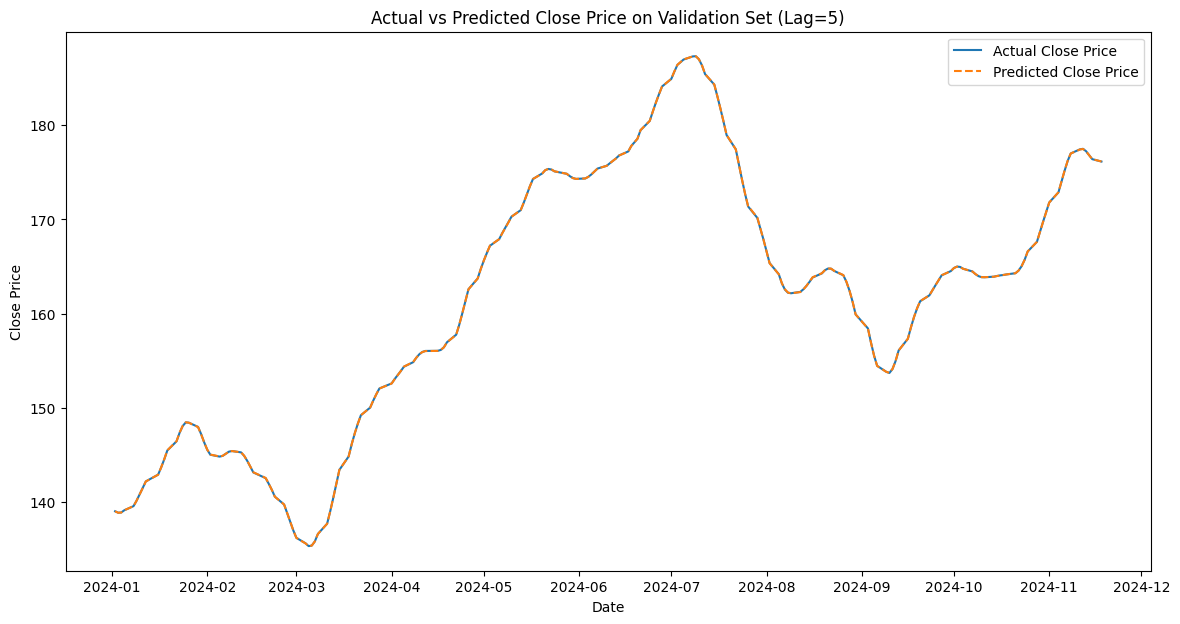


--- Lags: 6 ---
Validation MSE: 4.802709161302625e-05
Validation RMSE: 0.006930158123234003
Validation MAE: 0.005631972981872562
Linear Regression Equation:
y = 0.0051 + (5.3739) * close_t-1 + (-12.4343) * close_t-2 + (15.8813) * close_t-3 + (-11.8161) * close_t-4 + (4.8552) * close_t-5 + (-0.8599) * close_t-6
Predicted vs Actual Close Prices:


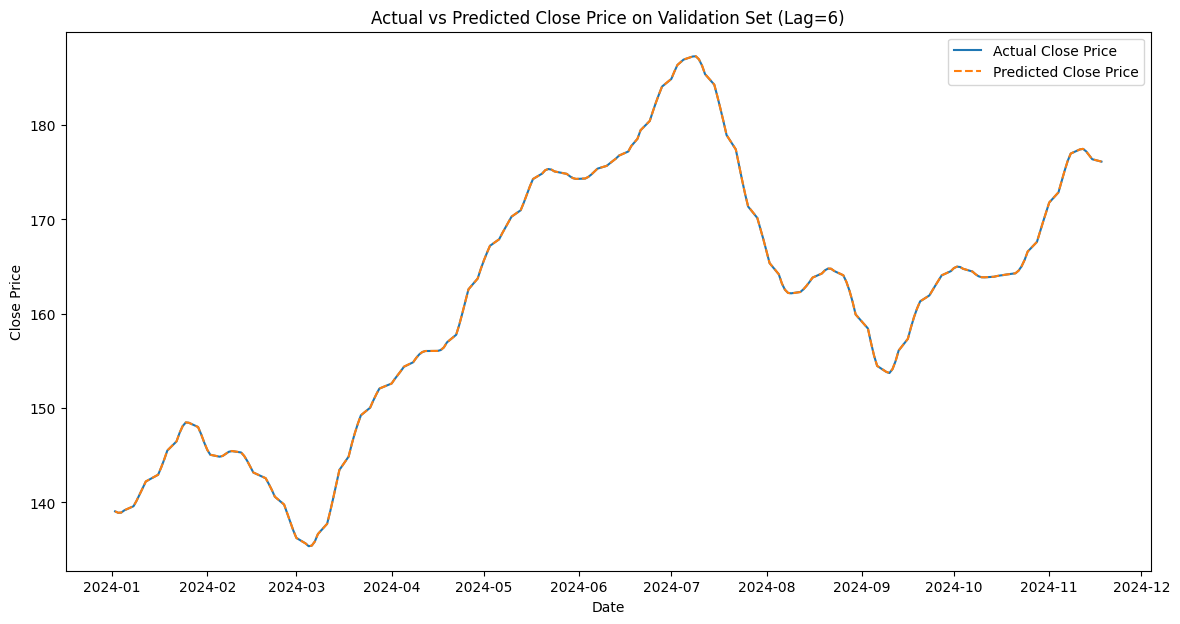


--- Lags: 7 ---
Validation MSE: 1.1074152482270945e-05
Validation RMSE: 0.0033277849212758545
Validation MAE: 0.0026303942805102217
Linear Regression Equation:
y = 0.0009 + (6.0863) * close_t-1 + (-16.4568) * close_t-2 + (25.6710) * close_t-3 + (-24.9738) * close_t-4 + (15.1569) * close_t-5 + (-5.3121) * close_t-6 + (0.8285) * close_t-7
Predicted vs Actual Close Prices:


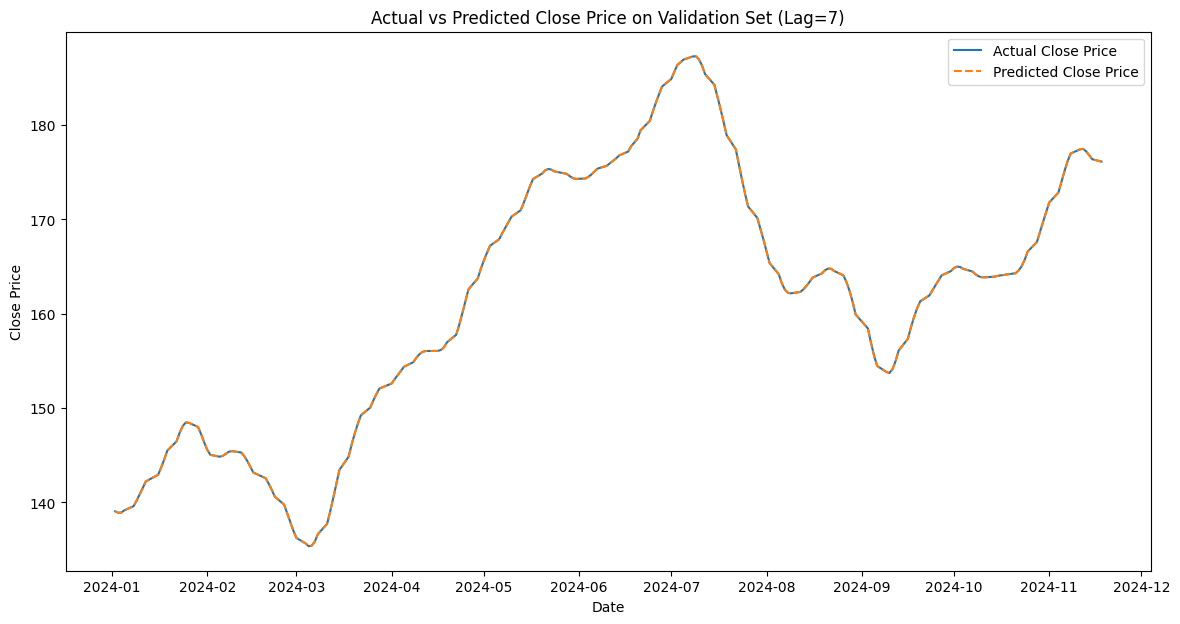

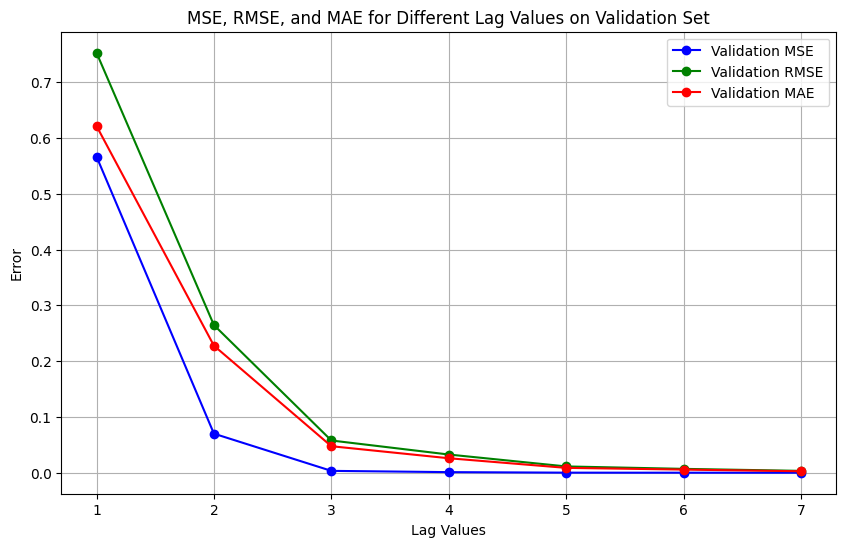

In [56]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib  # For saving the model and scaler

# 1. Load the data
df = pd.read_csv('/content/drive/MyDrive/alphavantage/close_prices.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()

# 2. Apply Gaussian Smoothing
sigma = 3
df['Close_smoothed'] = gaussian_filter1d(df['Close'], sigma=sigma)

# 3. List to store results
results_list = []

# Loop through lag values from 1 to 7
for lags in range(1, 8):
    # Add lagged features to the DataFrame
    for i in range(1, lags + 1):
        df[f'close_t-{i}'] = df['Close_smoothed'].shift(i)

    df = df.dropna()  # Drop any rows with NaN values after creating lags

    # 4. Split into training and validation sets
    train_data = df[df.index < '2024-01-01']
    validation_data = df[df.index >= '2024-01-01']
    #print(validation_data)

    # 5. x: train, y:validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, lags + 1)]].values
    y_train = train_data['Close_smoothed'].values
    X_validation = validation_data[[f'close_t-{i}' for i in range(1, lags + 1)]].values
    y_validation = validation_data['Close_smoothed'].values

    # 6. Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 7. Make predictions on the validation set
    validation_predictions = model.predict(X_validation)

    # 8. Evaluate the model
    validation_mse = mean_squared_error(y_validation, validation_predictions)
    validation_rmse = np.sqrt(mean_squared_error(y_validation, validation_predictions))
    validation_mae = mean_absolute_error(y_validation, validation_predictions)

    # Store results
    results_list.append({
        'lags': lags,
        'validation_mse': validation_mse,
        'validation_rmse': validation_rmse,
        'validation_mae': validation_mae,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'predictions': validation_predictions.flatten(),
        'actual': y_validation.flatten(),
        'dates': validation_data.index
    })

    # Store the model for lag 4
    if lags == 4:
        best_model = model
        joblib.dump(best_model, 'linear_regression_model.pkl')

    # 11. Print the coefficients and the linear regression equation
    coefficients = model.coef_
    intercept = model.intercept_

    # Create the linear equation
    linear_terms = [f'({coeff:.4f}) * close_t-{i}' for i, coeff in enumerate(coefficients, start=1)]
    linear_equation = f'y = {intercept:.4f} + ' + ' + '.join(linear_terms)
    print(f"\n--- Lags: {lags} ---")
    print(f"Validation MSE: {validation_mse}")
    print(f"Validation RMSE: {validation_rmse}")
    print(f"Validation MAE: {validation_mae}")
    print("Linear Regression Equation:")
    print(linear_equation)

    # 12. Create a DataFrame with Date, Actual, and Predicted values
    results_df = pd.DataFrame({
        'Date': validation_data.index,
        'Actual Close Price': y_validation.flatten(),
        'Predicted Close Price': validation_predictions.flatten()
    })

    # Print the results DataFrame
    print("Predicted vs Actual Close Prices:")
    #print(results_df.head())

    # 13. Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(validation_data.index, y_validation, label='Actual Close Price')
    plt.plot(validation_data.index, validation_predictions, label='Predicted Close Price', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs Predicted Close Price on Validation Set (Lag={lags})')
    plt.legend()
    plt.show()

# Extract the metrics for different lags
mse_values = [result['validation_mse'] for result in results_list]
rmse_values = [result['validation_rmse'] for result in results_list]
mae_values = [result['validation_mae'] for result in results_list]
lag_values = [result['lags'] for result in results_list]

# Plot MSE, RMSE, and MAE in the same graph
plt.figure(figsize=(10, 6))
plt.plot(lag_values, mse_values, marker='o', linestyle='-', color='b', label='Validation MSE')
plt.plot(lag_values, rmse_values, marker='o', linestyle='-', color='g', label='Validation RMSE')
plt.plot(lag_values, mae_values, marker='o', linestyle='-', color='r', label='Validation MAE')

plt.xlabel('Lag Values')
plt.ylabel('Error') # y-axis: error
plt.title('MSE, RMSE, and MAE for Different Lag Values on Validation Set')
plt.xticks(lag_values)  # x-axis: lag values
plt.legend()
plt.grid(True)
plt.show()


Με βάση το γράφημα, φαίνεται ότι οι μετρικές σφάλματος (MSE, RMSE και MAE) μειώνονται σημαντικά από το lag 1 έως το lag 2 και στη συνέχεια φθάνουν σε χαμηλές και σταθερές τιμές από το lag 3 και μετά. Μέχρι το lag 4, τα σφάλματα έχουν φθάσει σε  σταθερή κατάσταση, γεγονός που υποδηλώνει ότι τα πρόσθετα lag  πέραν αυτού του σημείου δεν παρέχουν ουσιαστική βελτίωση της ακρίβειας. Οπότε γι'αυτό και θα χρησιμοποιηθεί το μοντέλο που έχει δημιουργηθεί με τα 4 lag.


In [55]:
# 1. Load the best model (already saved with lag=4)
best_model = joblib.load('linear_regression_model.pkl')

# 2. Get the most recent 4 smoothed values for creating lag features
recent_data = df['Close_smoothed'].iloc[-4:].values  # Get the last 4 smoothed values

# Reshape the data to fit the model's expected input shape
next_day_features = recent_data.reshape(1, -1)

# 3. Make the prediction for the next day
next_day_prediction = best_model.predict(next_day_features)

print(f"Predicted Close Price for the next day: {next_day_prediction[0]:.2f}")



Predicted Close Price for the next day: 177.54


# **ΕΡΩΤΗΜΑ 2**





Lags: 1, Polynomial Degree: 1
Test MSE: 0.5665, RMSE: 0.7526, MAE: 0.6212

Lags: 1, Polynomial Degree: 2
Test MSE: 0.5665, RMSE: 0.7527, MAE: 0.6213

Lags: 1, Polynomial Degree: 3
Test MSE: 0.5661, RMSE: 0.7524, MAE: 0.6202


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 4
Test MSE: 0.5653, RMSE: 0.7519, MAE: 0.6190


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 5
Test MSE: 0.5666, RMSE: 0.7527, MAE: 0.6213


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 6
Test MSE: 0.5678, RMSE: 0.7535, MAE: 0.6232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 7
Test MSE: 0.5673, RMSE: 0.7532, MAE: 0.6232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 8
Test MSE: 0.5656, RMSE: 0.7521, MAE: 0.6212


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+05, tolerance: 1.817e+05
  model = cd_fast.enet_coordinate_descent(



Lags: 1, Polynomial Degree: 9
Test MSE: 0.5643, RMSE: 0.7512, MAE: 0.6188

Lags: 2, Polynomial Degree: 1
Test MSE: 0.1882, RMSE: 0.4339, MAE: 0.3298

Lags: 2, Polynomial Degree: 2
Test MSE: 0.2695, RMSE: 0.5191, MAE: 0.4023

Lags: 2, Polynomial Degree: 3
Test MSE: 0.2891, RMSE: 0.5377, MAE: 0.4387

Lags: 2, Polynomial Degree: 4
Test MSE: 0.3100, RMSE: 0.5568, MAE: 0.4543

Lags: 2, Polynomial Degree: 5
Test MSE: 0.3186, RMSE: 0.5644, MAE: 0.4613

Lags: 2, Polynomial Degree: 6
Test MSE: 0.3208, RMSE: 0.5664, MAE: 0.4658

Lags: 2, Polynomial Degree: 7
Test MSE: 0.3206, RMSE: 0.5662, MAE: 0.4687

Lags: 2, Polynomial Degree: 8
Test MSE: 0.3194, RMSE: 0.5652, MAE: 0.4700

Lags: 2, Polynomial Degree: 9
Test MSE: 0.3179, RMSE: 0.5638, MAE: 0.4702

Lags: 3, Polynomial Degree: 1
Test MSE: 0.1628, RMSE: 0.4035, MAE: 0.3201

Lags: 3, Polynomial Degree: 2
Test MSE: 0.2441, RMSE: 0.4941, MAE: 0.3744

Lags: 3, Polynomial Degree: 3
Test MSE: 0.2406, RMSE: 0.4905, MAE: 0.3991

Lags: 3, Polynomial Degr

<ipython-input-49-259a91b3ecd5>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_degrees)  # Use 'viridis' or any other colormap


<Figure size 1400x1000 with 0 Axes>

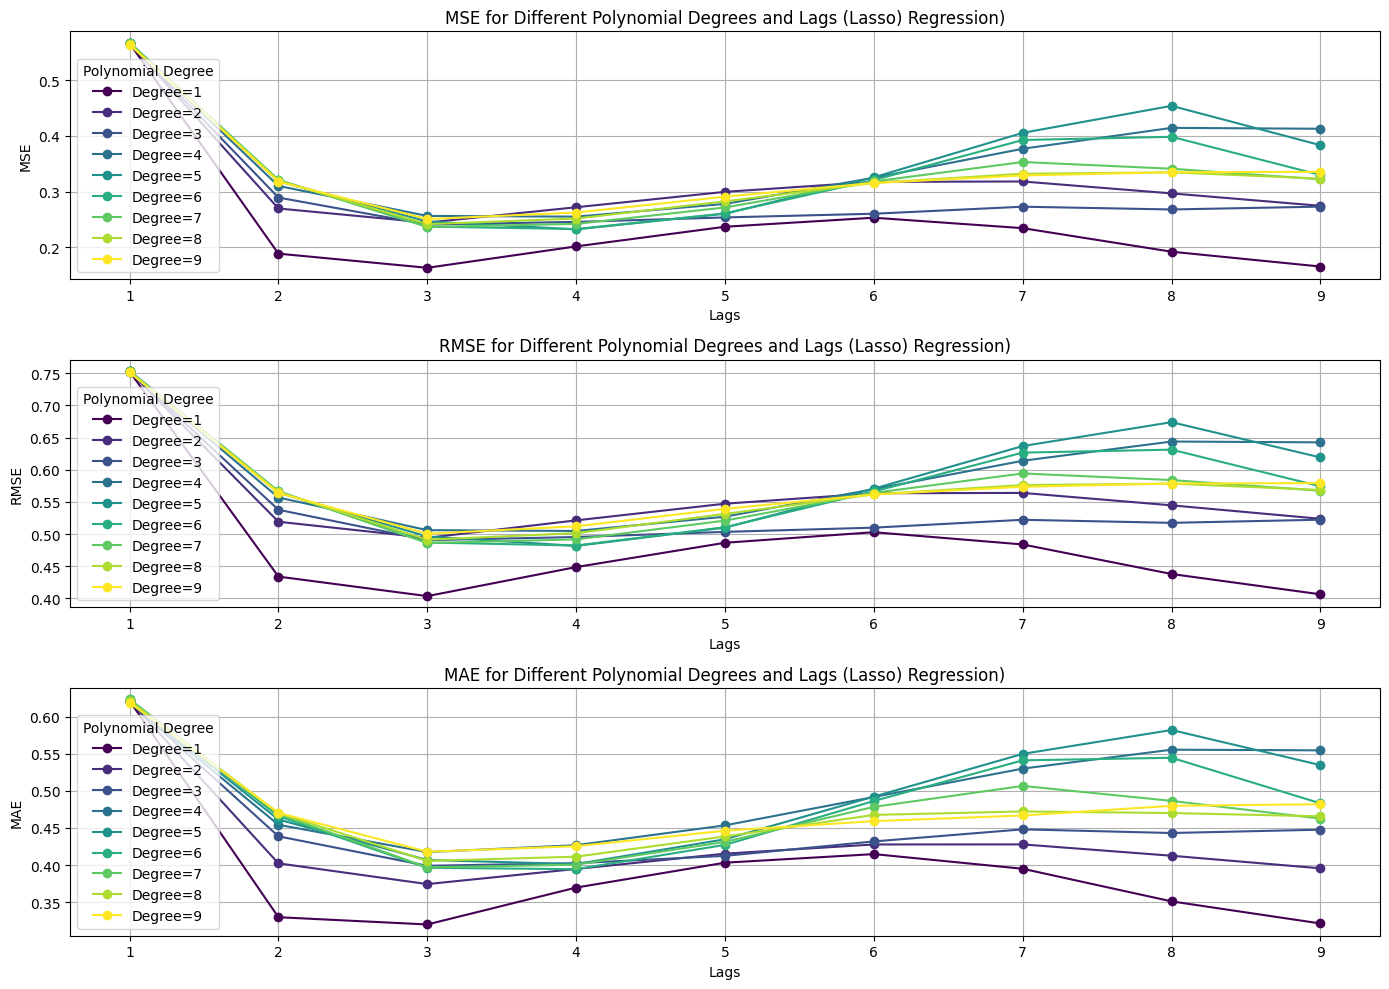

In [49]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import joblib  # For saving the model and scaler

# 1. Load the data
df = pd.read_csv('/content/drive/MyDrive/alphavantage/close_prices.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()  # Ensure the data is sorted by date

# 2. Apply Gaussian Smoothing
sigma = 3
df['Close_smoothed'] = gaussian_filter1d(df['Close'], sigma=sigma)

# 3. Prepare to store results
results_list = []

# Loop through lag values from 1 to 7
for lags in range(1, 10):
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['Close_smoothed'].shift(i)

    df = df.dropna()

    # 4. Split into training and testing sets
    train_data = df[df.index < '2024-01-01']
    test_data = df[df.index >= '2024-01-01']

    # 6. Prepare input (X) and target (y) for train and test sets
    X_train = train_data[[f'lag_{i}' for i in range(1, lags + 1)]].values
    y_train = train_data['Close_smoothed'].values
    X_test = test_data[[f'lag_{i}' for i in range(1, lags + 1)]].values
    y_test = test_data['Close_smoothed'].values

    # Loop through polynomial degrees from 1 to 10
    for degree in range(1, 10):
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # 7. Train the Lasso (L1-regularized) polynomial regression model
        model = Lasso(alpha=1, max_iter=10000)
        model.fit(X_train_poly, y_train)

        # 8. Make predictions on the test set
        test_predictions = model.predict(X_test_poly)

        # 9. Evaluate the model
        test_mse = mean_squared_error(y_test, test_predictions)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, test_predictions)

        # Store results
        results_list.append({
            'lags': lags,
            'degree': degree,
            'test_mse': test_mse,
            'test_rmse': test_rmse,
            'test_mae': test_mae
        })

        print(f"\nLags: {lags}, Polynomial Degree: {degree}")
        print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

        # Save the model if lag=5 and degree=1
        if lags == 4 and degree == 1:
            joblib.dump(model, 'lasso_model_lag_5_degree_1.pkl')
            print("Model saved for lag=5 and degree=1.")

# 10. Visualization of the results
# Create a results dataframe for easy analysis
results_df = pd.DataFrame(results_list)

# Plot the metrics (MSE, RMSE, MAE) for different lags and polynomial Degrees
plt.figure(figsize=(14, 10))

# Plot for MSE, RMSE, and MAE with lags on the x-axis
metrics = ['test_mse', 'test_rmse', 'test_mae']
metric_labels = ['MSE', 'RMSE', 'MAE']

# Determine the number of polynomial degrees dynamically
unique_degrees = results_df['degree'].unique()
num_degrees = len(unique_degrees)

# Generate a colormap
colormap = cm.get_cmap('viridis', num_degrees)  # Use 'viridis' or any other colormap

plt.figure(figsize=(14, 10))

for idx, metric in enumerate(metrics):
    plt.subplot(3, 1, idx + 1)  # Create subplots for each metric
    for degree_idx, degree in enumerate(unique_degrees):  # Loop through unique polynomial degrees
        degree_df = results_df[results_df['degree'] == degree]
        color = colormap(degree_idx / num_degrees)  # Dynamically assign a color
        plt.plot(degree_df['lags'], degree_df[metric],
                 marker='o', linestyle='-', color=color,
                 label=f'Degree={degree}')
    plt.xlabel('Lags')
    plt.ylabel(metric_labels[idx])
    plt.title(f'{metric_labels[idx]} for Different Polynomial Degrees and Lags (Lasso) Regression)')
    plt.legend(title="Polynomial Degree")
    plt.grid(True)

plt.tight_layout()
plt.show()




Lags: 1, Polynomial Degree: 1
Test MSE: 0.5666314812308441, RMSE: 0.7527492817869998, MAE: 0.6214899934792081

Lags: 1, Polynomial Degree: 2
Test MSE: 0.5650658217846787, RMSE: 0.7517086016434019, MAE: 0.6182505183139904

Lags: 1, Polynomial Degree: 3
Test MSE: 0.5684236347224185, RMSE: 0.7539387473279368, MAE: 0.6237238096430624

Lags: 1, Polynomial Degree: 4
Test MSE: 0.5687348895428733, RMSE: 0.754145138247853, MAE: 0.6240624796893283

Lags: 2, Polynomial Degree: 1
Test MSE: 0.07001466734140226, RMSE: 0.2646028483244318, MAE: 0.22767384009525898

Lags: 2, Polynomial Degree: 2
Test MSE: 0.10176397930063813, RMSE: 0.3190046697160374, MAE: 0.2411419227512513

Lags: 2, Polynomial Degree: 3
Test MSE: 0.1070804666062132, RMSE: 0.32723151835697795, MAE: 0.2495899989356317

Lags: 2, Polynomial Degree: 4
Test MSE: 0.03460545676992431, RMSE: 0.18602541968753708, MAE: 0.14486760176221894

Lags: 3, Polynomial Degree: 1
Test MSE: 0.0033391785803816043, RMSE: 0.05778562607068997, MAE: 0.04751841

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.01977e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.59827e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.2877e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.34074e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning


Lags: 3, Polynomial Degree: 4
Test MSE: 0.003915120066082029, RMSE: 0.06257092029115466, MAE: 0.0499839576565076

Lags: 4, Polynomial Degree: 1
Test MSE: 0.0010607383615655953, RMSE: 0.03256897851584534, MAE: 0.025869612976276532

Lags: 4, Polynomial Degree: 2
Test MSE: 0.001090415766545537, RMSE: 0.033021444040888595, MAE: 0.025876991461527703

Lags: 4, Polynomial Degree: 3
Test MSE: 0.001642871001109498, RMSE: 0.040532345122253885, MAE: 0.032235203726117774

Lags: 4, Polynomial Degree: 4
Test MSE: 0.0038026204042800505, RMSE: 0.061665390652132016, MAE: 0.0518837947181734


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.02777e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.68754e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Lags: 5, Polynomial Degree: 1
Test MSE: 0.00016637692441634282, RMSE: 0.012898717936924693, MAE: 0.009973027717923095

Lags: 5, Polynomial Degree: 2
Test MSE: 0.0007506322585787428, RMSE: 0.02739766885300176, MAE: 0.02170598051847478

Lags: 5, Polynomial Degree: 3
Test MSE: 0.0011721875021603505, RMSE: 0.034237223926018745, MAE: 0.026939170934238033

Lags: 5, Polynomial Degree: 4
Test MSE: 0.008081566447181915, RMSE: 0.08989753304280332, MAE: 0.0788544846276312

Lags: 6, Polynomial Degree: 1
Test MSE: 0.00019947216763945618, RMSE: 0.014123461602576621, MAE: 0.010877731797446173

Lags: 6, Polynomial Degree: 2
Test MSE: 0.00046560740511335675, RMSE: 0.021577937925421807, MAE: 0.017082823010884676

Lags: 6, Polynomial Degree: 3
Test MSE: 0.001016139739049734, RMSE: 0.03187694682760151, MAE: 0.02543497664757831

Lags: 6, Polynomial Degree: 4
Test MSE: 0.017891510027931726, RMSE: 0.13375914932419286, MAE: 0.11512565106788683

Lags: 7, Polynomial Degree: 1
Test MSE: 0.00014614386670825665, 

<ipython-input-52-e28c3ba89049>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_degrees)  # Use 'viridis' or any other colormap


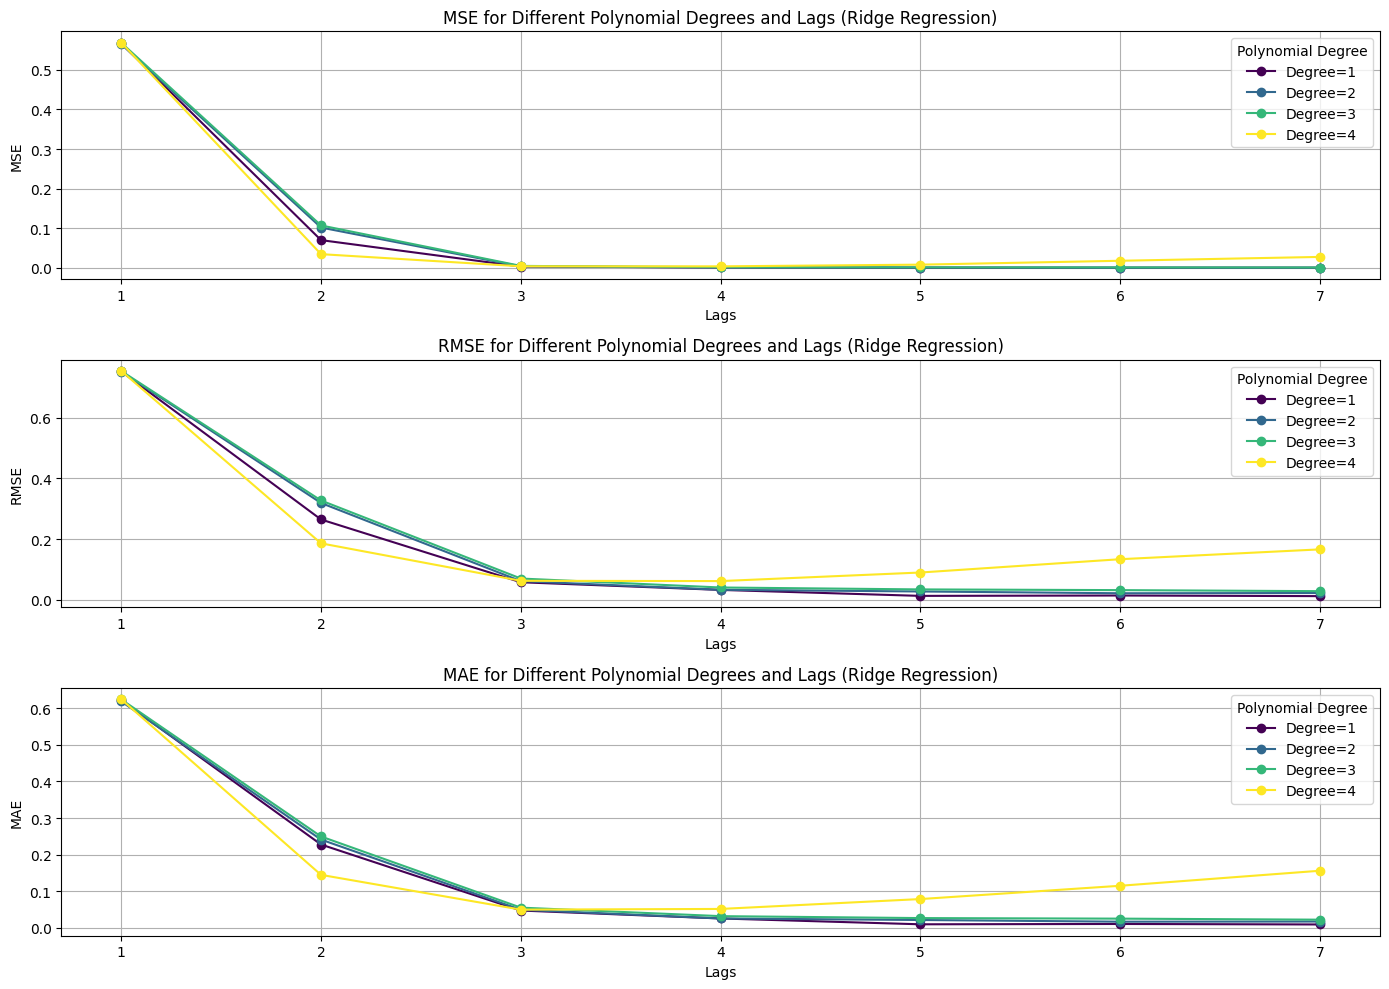

In [52]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Load the data
df = pd.read_csv('/content/drive/MyDrive/alphavantage/close_prices.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()  # Ensure the data is sorted by date

# 2. Apply Gaussian Smoothing
sigma = 3 # Set the sigma for smoothing
df['Close_smoothed'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Prepare to store results
results_list = []

# Loop for lags from 1 to 10
for lags in range(1, 8):
    # Create lagged features for the current lag number
    df = df[['Close_smoothed']].copy()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['Close_smoothed'].shift(i)

    df = df.dropna()  # Drop NaN values after creating the lagged features

    # Split into training and testing set
    train_data = df[df.index < '2024-01-01']
    test_data = df[df.index >= '2024-01-01']

    # Prepare input (X) and target (y) for train and test sets
    X_train = train_data[[f'lag_{i}' for i in range(1, lags + 1)]].values
    y_train = train_data['Close_smoothed'].values
    X_test = test_data[[f'lag_{i}' for i in range(1, lags + 1)]].values
    y_test = test_data['Close_smoothed'].values

    # Inner loop for polynomial degrees from 1 to 4
    for degree in range(1, 5):
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Train the Ridge (L2-regularized) polynomial regression model
        model = Ridge(alpha=1, max_iter=10000)
        model.fit(X_train_poly, y_train)

        # Make predictions on the test set
        test_predictions = model.predict(X_test_poly)

        # Evaluate the model using MSE, RMSE, and MAE
        test_mse = mean_squared_error(y_test, test_predictions)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, test_predictions)

        # Store results
        results_list.append({
            'lags': lags,
            'degree': degree,
            'test_mse': test_mse,
            'test_rmse': test_rmse,
            'test_mae': test_mae
        })

        print(f"\nLags: {lags}, Polynomial Degree: {degree}")
        print(f"Test MSE: {test_mse}, RMSE: {test_rmse}, MAE: {test_mae}")

        # Save the model
        if lags == 4 and degree == 3:
            joblib.dump(model, 'ridge_model.pkl')

# Create a result table for easier analysis
results_df = pd.DataFrame(results_list)


# Plot for MSE, RMSE, and MAE with lags on the x-axis
metrics = ['test_mse', 'test_rmse', 'test_mae']
metric_labels = ['MSE', 'RMSE', 'MAE']

# Determine the number of polynomial degrees dynamically
unique_degrees = results_df['degree'].unique()
num_degrees = len(unique_degrees)

# Generate a colormap
colormap = cm.get_cmap('viridis', num_degrees)  # Use 'viridis' or any other colormap

plt.figure(figsize=(14, 10))

for idx, metric in enumerate(metrics):
    plt.subplot(3, 1, idx + 1)  # Create subplots for each metric
    for degree_idx, degree in enumerate(unique_degrees):  # Loop through unique polynomial degrees
        degree_df = results_df[results_df['degree'] == degree]
        color = colormap(degree_idx / num_degrees)  # Dynamically assign a color
        plt.plot(degree_df['lags'], degree_df[metric],
                 marker='o', linestyle='-', color=color,
                 label=f'Degree={degree}')
    plt.xlabel('Lags')
    plt.ylabel(metric_labels[idx])
    plt.title(f'{metric_labels[idx]} for Different Polynomial Degrees and Lags (Ridge Regression)')
    plt.legend(title="Polynomial Degree")
    plt.grid(True)

plt.tight_layout()
plt.show()




In [51]:
import joblib
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Βήμα 1: Φόρτωση του αποθηκευμένου μοντέλου
ridge_model = joblib.load('ridge_model.pkl')

# Βήμα 2: Προετοιμασία των χαρακτηριστικών για πρόβλεψη
recent_values = df['Close_smoothed'].iloc[-4:].values
print("Recent values (lags):", recent_values)


# Δημιουργούμε ένα διάνυσμα για τα χαρακτηριστικά εισόδου
input_features = recent_values.reshape(1, -1)

# Βήμα 3: Μετασχηματισμός σε Polynomial Features
poly = PolynomialFeatures(degree=3)  # Χρησιμοποιούμε τον ίδιο βαθμό που εκπαιδεύτηκε το μοντέλο
input_poly = poly.fit_transform(input_features)

# Βήμα 4: Πρόβλεψη
next_day_prediction = ridge_model.predict(input_poly)

# Εκτύπωση της πρόβλεψης
print("Πρόβλεψη για την επόμενη ημέρα:", next_day_prediction[0])


Recent values (lags): [177.22991563 176.80535094 176.38992384 176.13771983]
Πρόβλεψη για την επόμενη ημέρα: 177.60335563256672
